## Training Artificial Neural Networks

In [1]:
from pyaudi import gdual_double as gdual
from pyaudi import sin, cos, tanh
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We define the architecture of the network:

    Inputs: 3
    Hidden layers: 2 with 5 units/layer
    Outputs: 1

We will need the first order derivatives

In [2]:
n_units = [3, 5, 5, 1]
order = 1

#### Definition of parameters

We create symbolic variables for the weights with values drawn from $\mathcal N(0,1)$

In [3]:
def initialize_weights(n_units, order):

    weights = []

    for layer in range(1, len(n_units)):
        weights.append([])
        for unit in range(n_units[layer]):
            weights[-1].append([])
            for prev_unit in range(n_units[layer-1]):                
                symname = 'w_{{({0},{1},{2})}}'.format(layer, unit, prev_unit)
                w = gdual(np.random.randn(), symname , order)
                weights[-1][-1].append(w)
          
    return weights

weights = initialize_weights(n_units, order)                

And for the biases, initialized to 1

In [4]:
def initialize_biases(n_units, order):

    biases = []

    for layer in range(1, len(n_units)):
        biases.append([])
        for unit in range(n_units[layer]):
            symname = 'b_{{({0},{1})}}'.format(layer, unit)
            b = gdual(1, symname , order)
            biases[-1].append(b)
            
    return biases

biases = initialize_biases(n_units, order)            

#### Neural network as a gdual expression

We create a function which output is the expression (*gdual*) corresponding to the neural network

In [5]:
def N_f(inputs, w, b):
        
    prev_layer_outputs = inputs
    
    #Hidden layers
    for layer in range(len(weights)):
        
        this_layer_outputs = []
        
        for unit in range(len(weights[layer])):
            
            unit_output = 0
            unit_output += b[layer][unit]
            
            for prev_unit,prev_output in enumerate(prev_layer_outputs):
                unit_output += w[layer][unit][prev_unit] * prev_output
            
            if layer != len(weights)-1:
                unit_output = tanh(unit_output)
                
            this_layer_outputs.append(unit_output)
            
        prev_layer_outputs = this_layer_outputs

    return prev_layer_outputs

The new function can be used to compute the output of the network given any input:

In [6]:
x1 = 1
x2 = 2
x3 = 4

N = N_f([x1,x2, x3], weights, biases)[0]
print('N(x) = {0}'.format(N.constant_cf))
#N

N(x) = 2.565934265083211


#### Loss function

In our case the desired output of the network will be: $y(\mathcal x)= x_1x_2 + 0.5x_3 +2$

In [7]:
def y_f(x):
    return x[0]*x[1] + 0.5*x[2] + 2

y = y_f([x1,x2,x3])
print('y = {0}'.format(y))

y = 6.0


The training process will seek to minimize a loss function corresponding to the quadratic error. 

In [8]:
def loss_f(N,y):
    return (N-y)**2

loss = loss_f(N, y)
print('loss = {0}'.format(loss.constant_cf))
#loss

loss = 11.792807471729587


The function loss_f accepts a gdual (N) and a float (y) and the output still a gdual, which will make it possible to compute its derivatives wrt any of the parameters of the network:

In [9]:
for symbol in loss.symbol_set[-10:]:
    print(symbol)

w_{(2,4,0)}
w_{(2,4,1)}
w_{(2,4,2)}
w_{(2,4,3)}
w_{(2,4,4)}
w_{(3,0,0)}
w_{(3,0,1)}
w_{(3,0,2)}
w_{(3,0,3)}
w_{(3,0,4)}


#### Training (Gradient descent)

We update the weights with gradient descent using the first order derivatives of the loss function with respect to the weights (and biases)

In [10]:
def GD_update(loss, w, b, lr):
    
    #Update weights
    for layer in range(len(w)):
        for unit in range(len(w[layer])):
            for prev_unit in range(len(w[layer][unit])):
                
                weight = w[layer][unit][prev_unit]
                if weight.symbol_set[0] in loss.symbol_set:
                    symbol_idx = loss.symbol_set.index(weight.symbol_set[0])
                    d_idx = [0]*loss.symbol_set_size                                                      
                    d_idx[symbol_idx] = 1
                    
                    # eg. if d_idx = [1,0,0,0,...] get get the derivatives of loss wrt
                    # the first symbol (variable) in loss.symbol_set
                    w[layer][unit][prev_unit] -= loss.get_derivative(d_idx) * lr

    #Update biases
    for i in range(len(b)):
        for j in range(len(b[layer])):
            
                bias = b[layer][unit]
                if bias.symbol_set[0] in loss.symbol_set:
                    symbol_idx = loss.symbol_set.index(bias.symbol_set[0])
                    d_idx = [0]*loss.symbol_set_size                    
                    d_idx[symbol_idx] = 1
                    b[layer][unit] -= loss.get_derivative(d_idx) * lr

    return w,b

After one GD step the loss function decrases

In [11]:
weights, biases = GD_update(loss, weights, biases, 0.01) 

N = N_f([x1,x2,x3], weights, biases)[0]
loss = loss_f(N, y)
print('loss = {0}'.format(loss.constant_cf))


loss = 5.648639112617553


Doing the same for several data points

In [12]:
X = -1+2*np.random.rand(10,3)

epoch 49, training loss: 0.10428705104913479


Text(0,0.5,'loss')

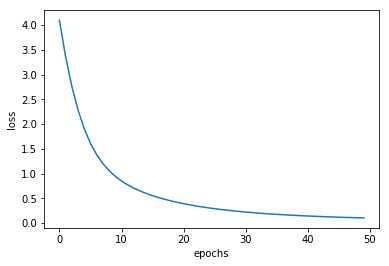

In [13]:
loss_history = []

weights = initialize_weights(n_units, order)                
biases = initialize_biases(n_units, order)            


epochs = 50

for e in range(epochs):
        
    #Just records the error at the beginning of this step
    epoch_loss = []
    for xi in X:
        N = N_f(xi, weights, biases)[0]
        loss = loss_f(N, y_f(xi))
        epoch_loss.append(loss.constant_cf)    
        
    loss_history.append(np.mean(epoch_loss))
    
    #Updates the weights
    for xi in X:
        N = N_f(xi, weights, biases)[0]
        loss = loss_f(N, y_f(xi))
        weights, biases = GD_update(loss, weights, biases, 0.001)     

print('epoch {0}, training loss: {1}'.format(e, loss_history[-1]))        
plt.plot(loss_history)
plt.xlabel('epochs')
plt.ylabel('loss')